# Local Adressability with DMM

In [1]:
import numpy as np

from dataclasses import replace

from matplotlib import pyplot as plt

from pulser.channels.dmm import DMM
from pulser.devices import AnalogDevice
from pulser.register import Register
from pulser.register.register_layout import RegisterLayout
from pulser.register.mappable_reg import MappableRegister
from pulser.register.weight_maps import DetuningMap
from pulser.sampler import sampler
from pulser.sequence import Sequence
from pulser.pulse import Pulse
from pulser.waveforms import ConstantWaveform, RampWaveform

## Introduction

Even when working with **global** addressing channels, the **detuning** of individual qubits can be addressed **locally** by using a specific channel named the **Detuning Map Modulator** or `DMM`.

This `Channel` applies a `Global` pulse of **zero amplitude** and **negative detuning** on a `DetuningMap`. The `DetuningMap` consists of a set of weights on specific sites that dictate the proportion of detuning applied by the `DMM` each site receives.

This modulation of the `DetuningMap` by the `DMM` Channel is equivalent to adding a term $-\frac{\hbar}{2}\sum_{i}\epsilon_{i}\Delta(t)\sigma^{z}_{i}$ to the Ising Hamiltonian. Here, $\Delta(t)$ is the detuning applied on the `DMM`, and $(\epsilon_i)_{i}$ are the weights defined in the `DetuningMap` for each atom.

## Define a Detuning Map

A `DetuningMap` associates a set of locations with a set of weights. The locations are the trap coordinates to address and the weights $(\epsilon_i)_i$ have to be between 0 and 1.

In [2]:
trap_coordinates = [(0.0, 0.0), (0.0, 5.0), (5.0, 0.0), (5.0, 5.0)]
weights_1 = [1.0, 0.5, 0.5, 0]  # between 0 and 1
weights_2 = [1.0, 1.0, 1.0, 0]  # between 0 and 1

The `DetuningMap` can be defined from a `RegisterLayout`, a `Register` or a `MappableRegister` by using the `define_detuning_map` method. All it takes is a mapping between trap/qubit IDs and weights.

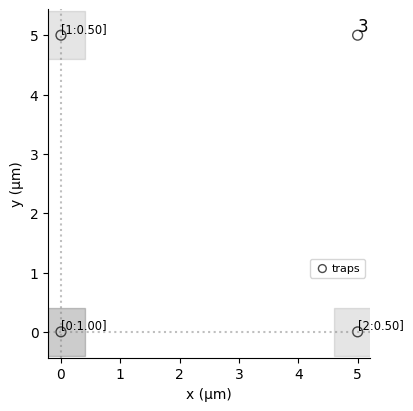

In [3]:
register_layout = RegisterLayout(trap_coordinates)
detuning_map = register_layout.define_detuning_map(
    {i: weights_1[i] for i in range(4)}  # mapping between trap ids and weights
)

map_reg = MappableRegister(register_layout)
det_map_from_map_reg = map_reg.define_detuning_map(
    {i: weights_1[i] for i in range(4)}  # mapping between trap ids and weights
)

register = Register.from_coordinates(
    trap_coordinates, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights_1[i] for i in range(4)
    }  # mapping between qubit ids and weights
)

detuning_map.draw(labels=[0, 1, 2, 3])
assert detuning_map == det_map_from_map_reg
assert detuning_map == det_map_from_reg

The traps are represented by a grey dot and highlighted by a grey square, whose shade is proportional to the value of the associated weight. It is possible to display the value of the weights by specifying a list of `labels`. If the weight is null then no `DMM` is applied: the atom is not highlighted by a grey square and the value of the weight is not shown when `labels` are specified.

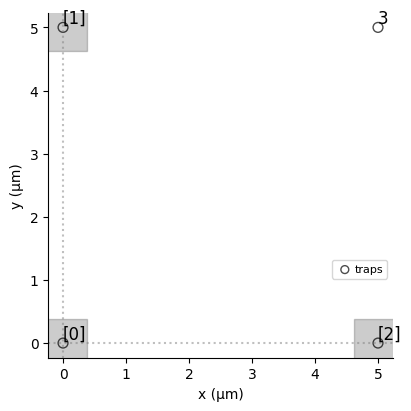

In [4]:
detuning_map_2 = register_layout.define_detuning_map(
    {i: weights_2[i] for i in range(4)}  # mapping between trap ids and weights
)
detuning_map_2.draw(labels=[0, 1, 2, 3])

## DMM Channel and Device

A `DMM` Channel is a `Channel` that accepts pulses of zero amplitude and detuning below 0 and above:
- `bottom_detuning` for each site.
- `total_bottom_detuning` for the total detuning distributed among the atoms:

In [5]:
dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-2 * np.pi * 20,  # detuning between 0 and -20 MHz
    total_bottom_detuning=-2 * np.pi * 2000,  # total detuning
)

The `DMM` channels are defined separately from the other channels of the device. They are defined as a list in `dmm_objects`. They can be accessed via the property `dmm_channels` of the device, where an id is automatically associated to each `DMM` with the format `dmm_{index of appearance in dmm_objects}`.

In [6]:
mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)
print(mock_device.dmm_channels)

{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=-125.66370614359172, total_bottom_detuning=-12566.370614359172), 'dmm_1': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=100000000, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=None, total_bottom_detuning=None)}


## DMM in a Sequence

In a `Sequence` defined with a `Device` having `dmm_objects`, the `DMM` channels can be configured using `config_detuning_map`. This configuration associates a `DMM` - referenced by `dmm_id` in the `Device`- with a `DetuningMap`, under a `dmm_name` in the `Sequence`.

In [7]:
seq = Sequence(register, mock_device)
seq.config_detuning_map(detuning_map, "dmm_0")
print(seq.declared_channels)

{'dmm_0': DMM(addressing='Global', max_abs_detuning=None, max_amp=0, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=67108864, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=None, propagation_dir=None, bottom_detuning=-125.66370614359172, total_bottom_detuning=-12566.370614359172)}


The `dmm_name` is generated automatically. It is `dmm_id` if no detuning map has been associated to the `DMM` referenced by `dmm_id` in the device, otherwise it takes the suffix `_{number of times dmm_id has been declared so far}`. For instance, if we associate a new detuning map to `dmm_0` in the previous sequence, the name of this new declared channel will be `dmm_0_1`. To be noted that configuring a `dmm_id` multiple times is only possible in a `VirtualDevice` with `reusable_channels=True`.

In [8]:
seq.config_detuning_map(detuning_map_2, "dmm_0")
print(seq.declared_channels.keys())

dict_keys(['dmm_0', 'dmm_0_1'])


Let's now apply a global detuning on the detuning maps. This is done by calling `add_dmm_detuning` and providing a waveform (the detuning $\Delta(t)$ to modulate the `DetuningMap` with) and the `dmm_name` to use (provides the `DetuningMap` and checks that $\Delta(t)$ is in agreement with the characteristics of the corresponding `DMM`).

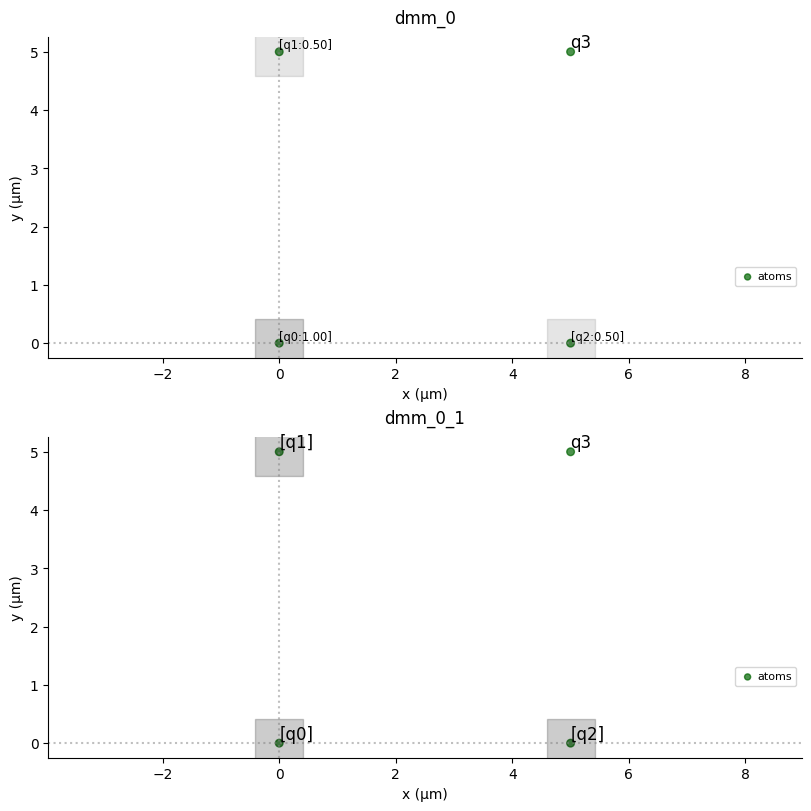

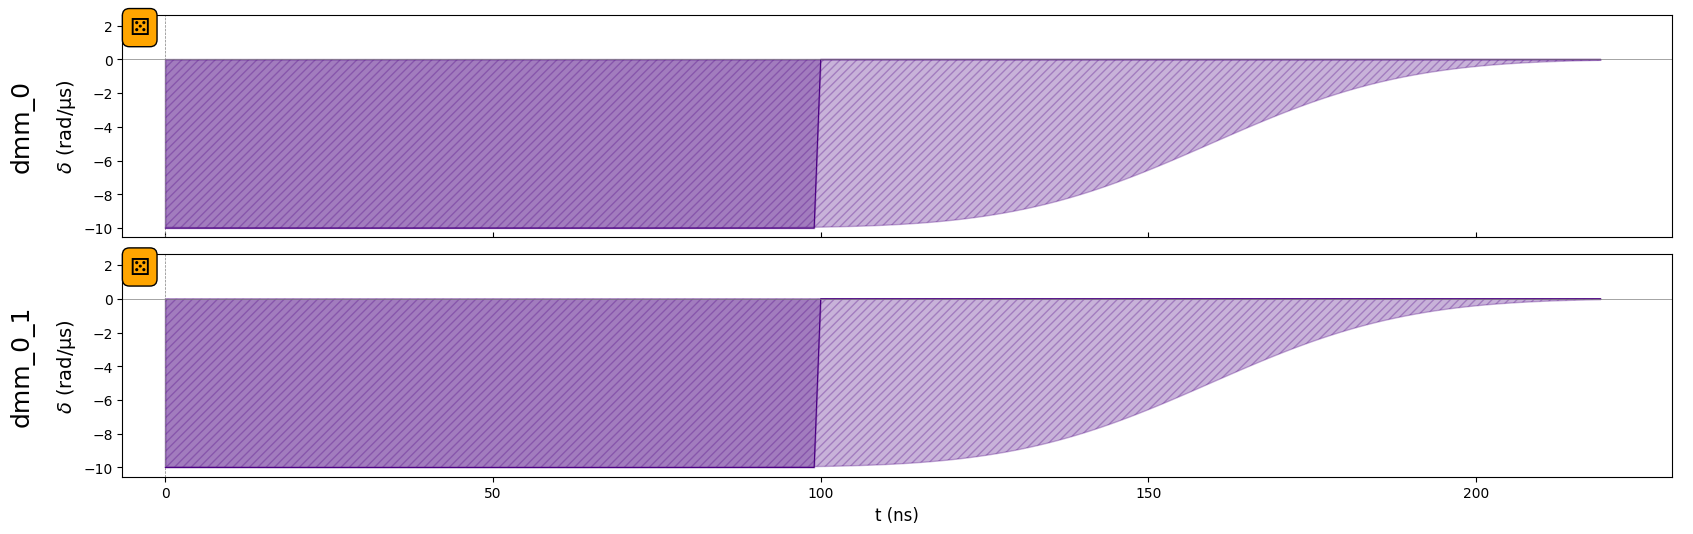

In [9]:
seq.add_dmm_detuning(ConstantWaveform(100, -10), "dmm_0")
seq.add_dmm_detuning(ConstantWaveform(100, -10), "dmm_0_1")
seq.draw(draw_detuning_maps=True)

Once a detuning map is configured, it is not possible to define a `Microwave` channel. However, it is possible to declare `Rydberg` and `Raman` channels. Let's declare a `Rydberg.Global` channel in our sequence.

In [10]:
seq.declare_channel("ryd_glob", "rydberg_global")

Be careful with the protocols that are used to add the pulses to `Channels` and `DMM`:
    
   - The protocol to add a waveform to a `DMM` is by default `"no-delay"`, meaning that it will be added straight after the last pulse, without caring about the other channels. This is why the pulse on `dmm_0_1` is added at $t=0$. It can be changed to other values by defining the `protocol` argument.
   - The protocol to add a pulse to a `Rydberg` or a `Raman` channel is `"min-delay"`, meaning that the pulse will by default be added after the end of the pulse of a `DMM`. It can be switched to `"no-delay"`.


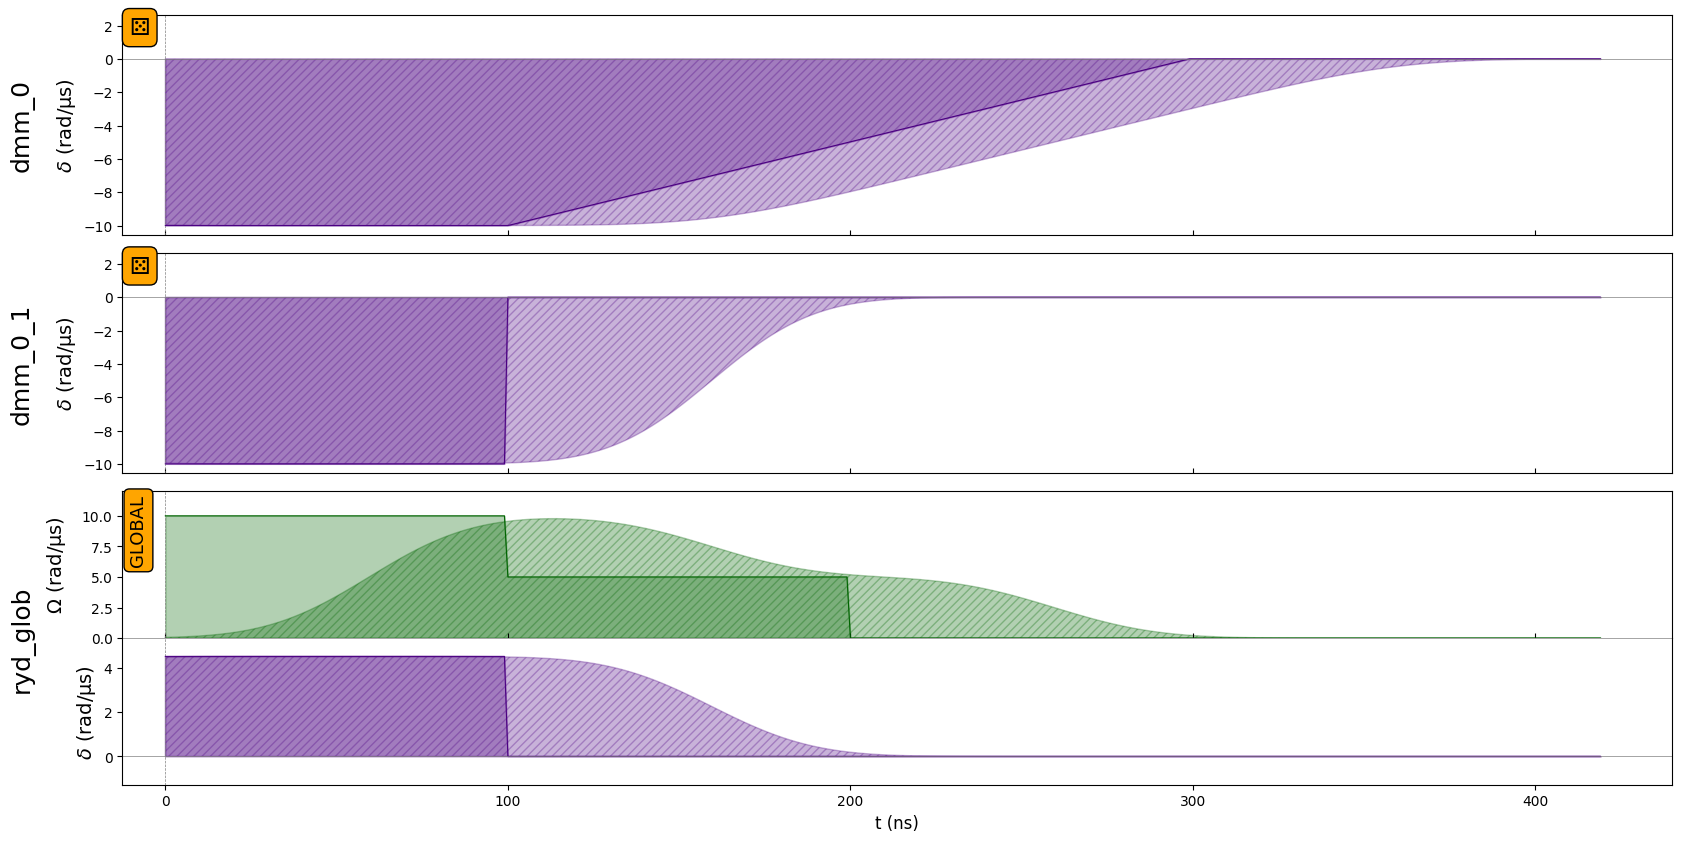

In [11]:
seq.add(
    Pulse.ConstantPulse(100, 10, 4.5, 0), "ryd_glob", protocol="no-delay"
)  # added at the beginning with protocol "no delay"
seq.add_dmm_detuning(RampWaveform(200, -10, 0), "dmm_0")  # added at t=100
seq.add(
    Pulse.ConstantPulse(100, 5, 0, 0), "ryd_glob", protocol="no-delay"
)  # added at t=100
seq.draw()

It is possible to display the amplitude and detuning per qubits, by setting to `True` the arguments `draw_qubit_amp` and `draw_qubit_det`. This adds two plots after the drawing of the sequence. The first one shows the evolution of these quantities along time for groups of qubits experiencing the same amplitude or detuning. The second represents these group of qubits on a register. 

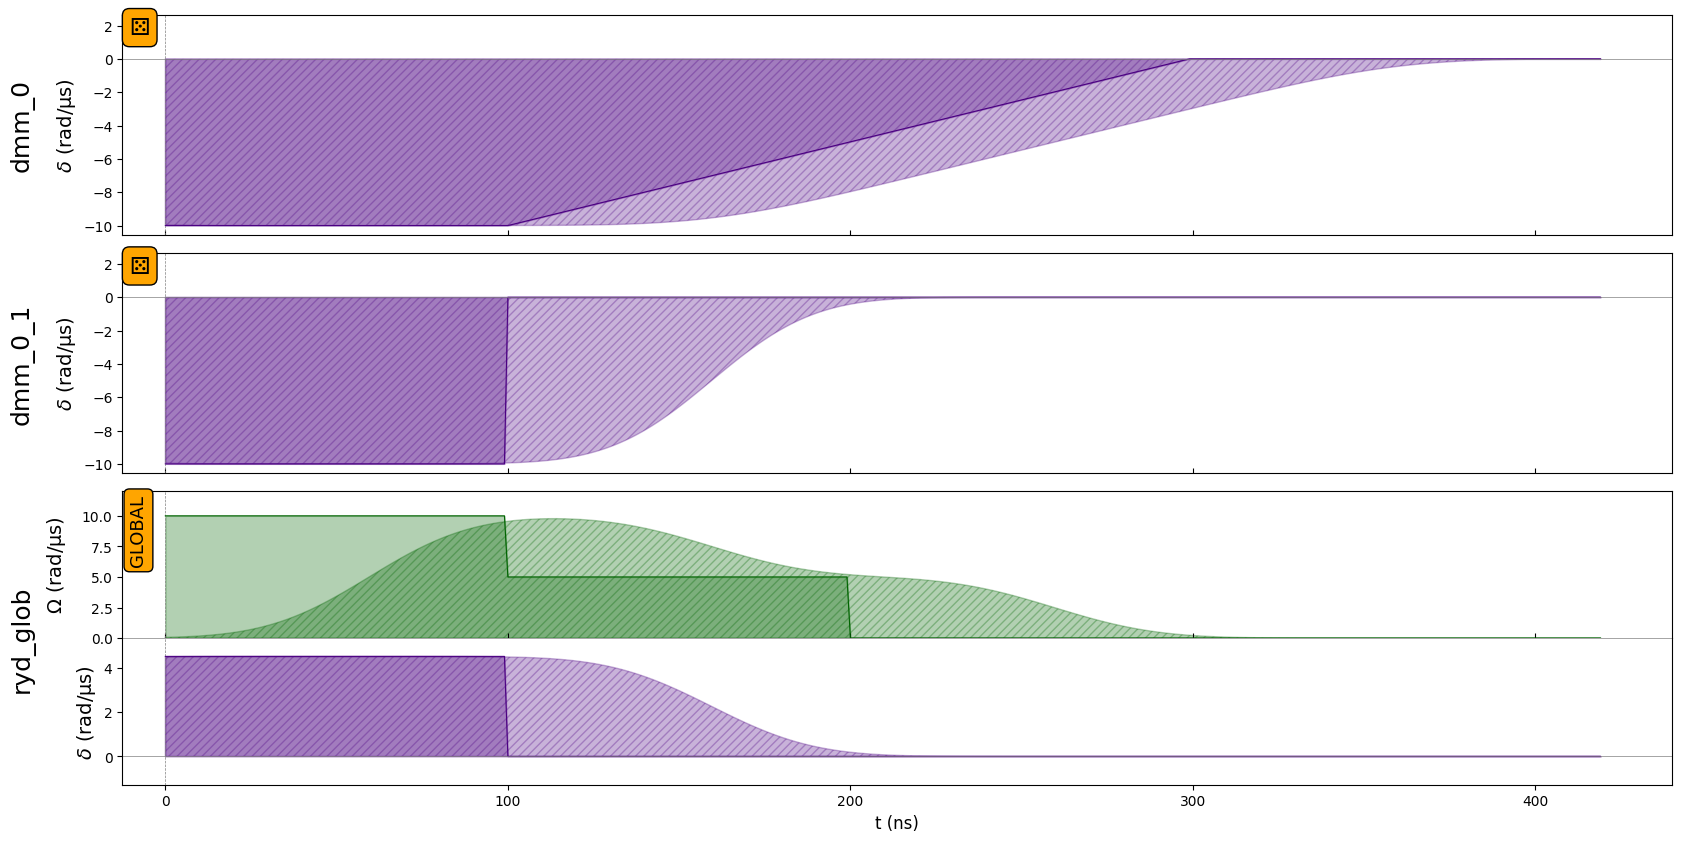

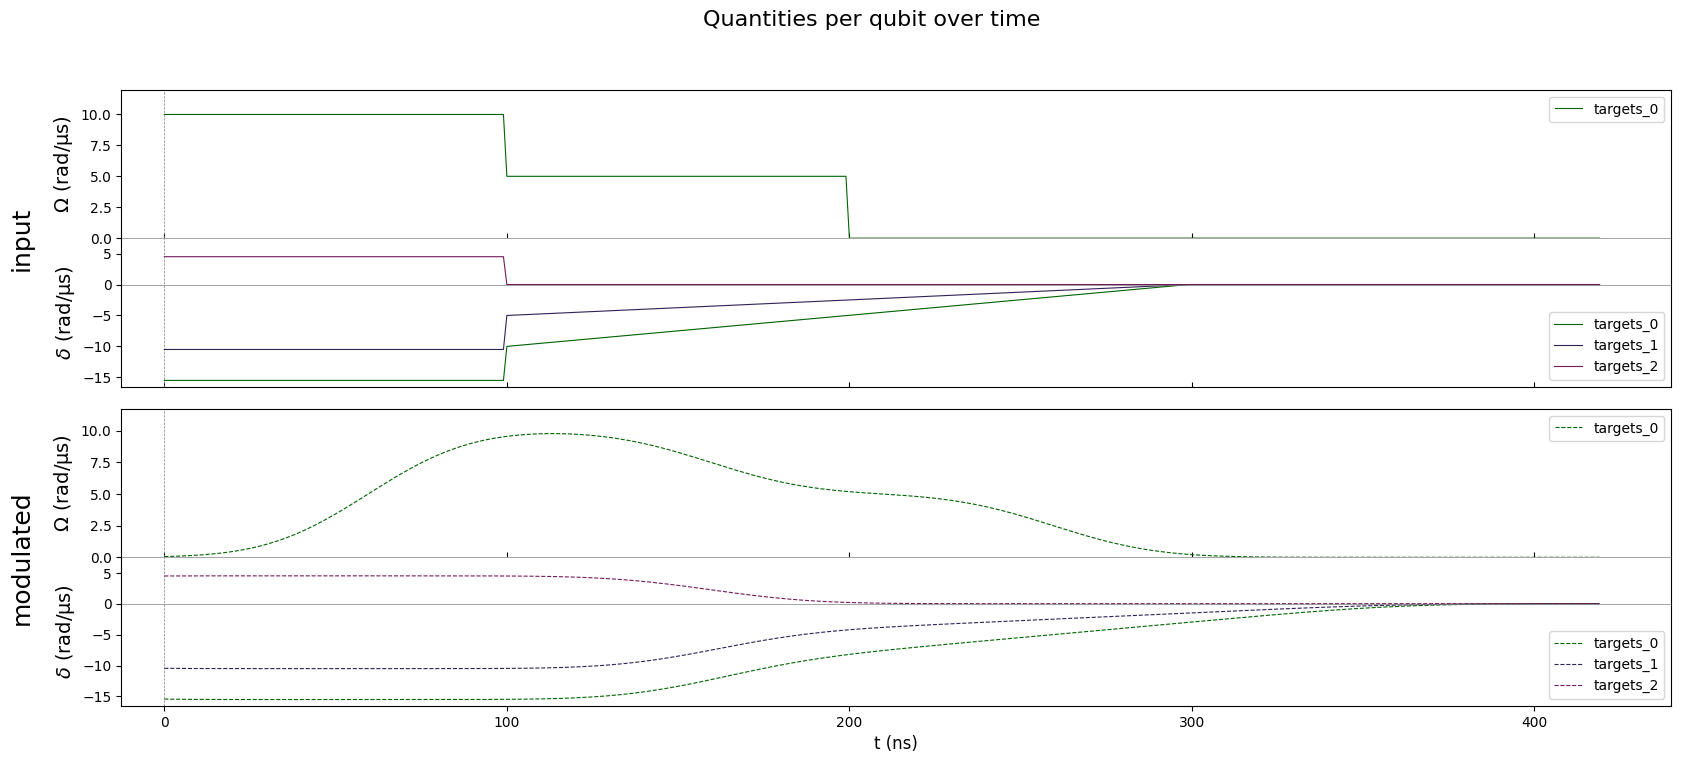

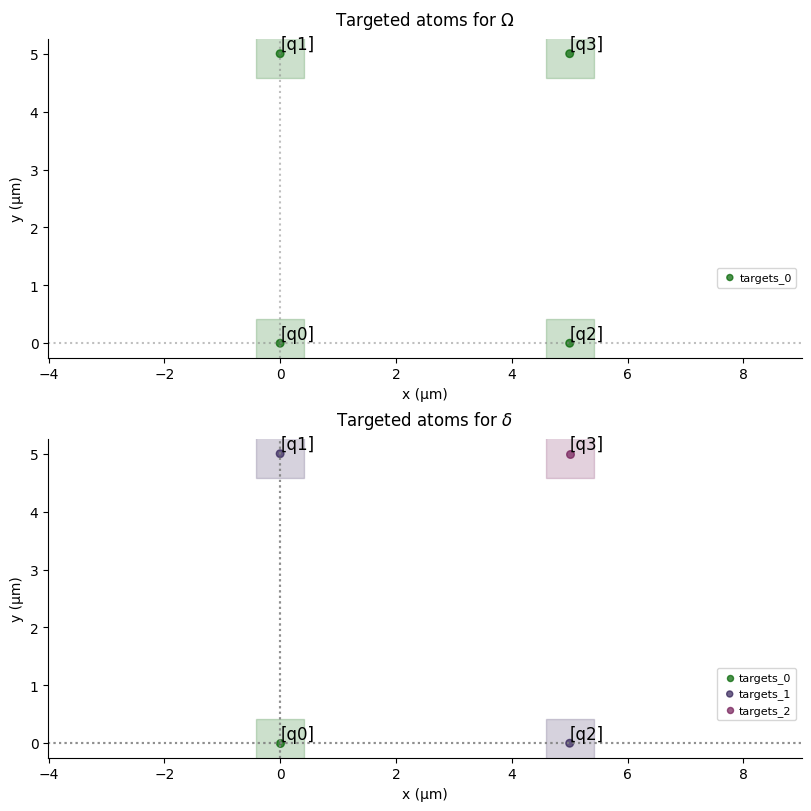

In [12]:
seq.draw(
    mode="input+output",  # "input" only shows input signals, "input+output"
    draw_qubit_det=True,
    draw_qubit_amp=True,
)

You can see that by combining a global pulse with a positive detuning and pulses on the `DMM` channels, it is possible to have **positive local detuning** (see the detuning on `q3` from `t=0` to `t=100ns`).

It can also be noted that from `t=100ns` to `t=300ns`, the local detuning is defined by the detuning ramp applied on `detuning_map`, hence it is locally a detuning ramp, going to 0 with a slope defined by the weight of `detuning_map` on each atom. This is why the detuning on `q3` during this duration is constant equal to 0 and that `q1` and `q2` have the same local detuning.